# 1.Preparation and reference

### In this notebook I have used KNN regression and Classification on Abalone  dataset  and further improved using Bagging and Boosting using python scikit and sklearn libraries.I sorry the font appears very large when converted to pdf and takes up a large part of the page.

### Abalone Data Set（abalone.data） from UCI Machine Learning Repository
http://archive.ics.uci.edu/ml/datasets/Abalone 

### Reference
[1]https://www.kaggle.com/code/errearanhas/knn-regression-bagging-on-abalone-data/notebook

[2]https://github.com/dineshtpalanisamy/KNN-Regression-and-Classification/blob/main/KNN%20Regressor%20and%20Classifier.ipynb

[3]https://medium.com/analytics-vidhya/ensemble-learning-bagging-f9329e07fc22               

by LYU.

# The Abalone Problem

### The age of an Abalone can be found by counting the number of rings on its cutted shell. In the Abalone Dataset, there are age measurements of Abalones, along with some physical measurements.

### The project goal is to apply a model to predict an Abalone's age based purely on its physical measurements. This would allow Abalone’s age estimation without having to cut its shell.In addition, we will also try to reduce the variables in order to save the measurement effort.

# KNN classifier and Bagging Problem

Is it pointless to use Bagging with nearest neighbor classifiers?    

--"It is pointless to bag nearest-neighbor classifiers because their output changes very little if the training data is perturbed by sampling."      

--"The lower k the more unstable the model will be. The more we modify the dataset, the higher probability the use a different set of neighbors. If you take k=1 and modify the dataset enough so the probability of getting the same neighbor is less then 80%, bagging should help. I think the the use case Breiman had in mind is a higher k and more delicate modifications. If you have k of 10 and probability of having the same neighbour of 99%, the results will be quite stable."

https://stats.stackexchange.com/questions/314526/is-it-pointless-to-use-bagging-with-nearest-neighbor-classifiers

In [276]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

np.set_printoptions(suppress=True)

# 2.Preprocessing

### According to the analysis results of last semester's report:

### The "Rings" variable is the number of abalone rings, which can represent the age of abalone and is a predictor variable. All are continuous variables except for "sex" which is a discrete feature.

### From the following analysis, we can learn that 
### ・There is no missing data.
### ・There are 4177 rows of data.
### ・There are no extreme values.
### ・The data are not normalized. 
### ・The scales are different for different variables.

In [277]:
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data" )
abalone = pd.read_csv(url, names=['Sex', 'Length','Diameter','Height','Whole_wt','Shucked_wt','Viscera_wt','Shell_wt','Rings'])
abalone.head()

,Sex,Length,Diameter,Height,Whole_wt,Shucked_wt,Viscera_wt,Shell_wt,Rings
0,M,0.4550,0.3650,0.0950,0.5140,0.2245,0.1010,0.1500,15
1,M,0.3500,0.2650,0.0900,0.2255,0.0995,0.0485,0.0700,7
2,F,0.5300,0.4200,0.1350,0.6770,0.2565,0.1415,0.2100,9
3,M,0.4400,0.3650,0.1250,0.5160,0.2155,0.1140,0.1550,10
4,I,0.3300,0.2550,0.0800,0.2050,0.0895,0.0395,0.0550,7


In [278]:
abalone.Sex = abalone.Sex.map({'M':0, 'F':1, 'I':2})

In [279]:
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sex         4177 non-null   int64  
 1   Length      4177 non-null   float64
 2   Diameter    4177 non-null   float64
 3   Height      4177 non-null   float64
 4   Whole_wt    4177 non-null   float64
 5   Shucked_wt  4177 non-null   float64
 6   Viscera_wt  4177 non-null   float64
 7   Shell_wt    4177 non-null   float64
 8   Rings       4177 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


<AxesSubplot: >

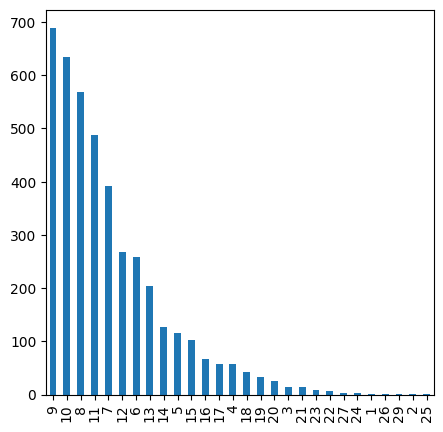

In [323]:
plt.figure(figsize=(5,5))
abalone['Rings'].value_counts().plot(kind='bar')

## The barplot shows us that most Abalones here are amongst 7 and 11 rings, with high predominance of 9 rings.Another clear conclusion is that older Abalones are underrepresented in this dataset.

Let's now check correlation between all features and "Rings", to get an intuition of features that can help us predicting "Rings":

In [281]:
abalone.corr()['Rings'].sort_values()

Sex          -0.3518
Shucked_wt    0.4209
Viscera_wt    0.5038
Whole_wt      0.5404
Length        0.5567
Height        0.5575
Diameter      0.5747
Shell_wt      0.6276
Rings         1.0000
Name: Rings, dtype: float64

### remove features "Sex" (it isn't a physical measurement) and "Shucked weight" (correlation under an arbitrary threshold of 0.5)


In [282]:
abalone_filter = abalone.drop(["Sex","Shucked_wt"], axis=1)


In [283]:
X = abalone_filter.drop('Rings', axis=1).values
y = abalone_filter['Rings'].values


# 3.Build KNN Regression model


First,apply a kNN with k = 3 on a new abalone that has the following physical measurements:

In [284]:
new_data_point = np.array([
    0.569552,#Length
    0.446407,#Diameter
    0.154437,#Height
    1.016849,#Whole_wt
    0.222526,#Viscera_wt
    0.291208,#Shell_wt 
 ])

In [285]:
distances = np.linalg.norm(X - new_data_point, axis=1)
print(distances)

[0.55753691 0.88922156 0.36234898 ... 0.18475359 0.11007487 0.98304435]


we now have a vector of distances, and we need to find out which are the three closest neighbors. To do this, we need to find the IDs of the minimum distances. we can use a method called .argsort() to sort the array from lowest to highest, and we can take the first k elements to obtain the indices of the k nearest neighbors:

In [286]:
k = 3
nearest_neighbor_ids = distances.argsort()[:k]
print(nearest_neighbor_ids)

[1902  993 1792]


This tells we which three neighbors are closest to your new_data_point. In the next paragraph, we'll see how to convert those neighbors in an estimation.

### Comparing with the results of reference [2], I simply dropped the Shucked_wt variable, however the ids of the nearest neighbors all changed. I found that the probability of neighbors' appearance is unstable when k is smaller.

### Voting or Averaging of Multiple Neighbors

In [287]:
nearest_neighbor_rings = y[nearest_neighbor_ids]
print(nearest_neighbor_rings)


[11 10  9]


In [288]:
prediction = nearest_neighbor_rings.mean()
print(prediction)


10.0


That is, we combine multiple neighbors into one prediction by taking the average of their target variable values. For the new data point, the prediction is 10rings.

### Feature Scaling

In [289]:
#Feature Scaling  MinMax Scaler
minmax=MinMaxScaler()
X=minmax.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [290]:
knn_model = KNeighborsRegressor(n_neighbors=3)

In [291]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [292]:
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
print(mse)
print(rmse)

3.144068642123117
1.7731521768091754


In [293]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

2.581036433226739

## Improving KNN Performances in scikit-learn Using GridSearchCV


Until now, we’ve always worked with k=3 in the kNN algorithm, but the best value for k is something that you need to find empirically for each dataset.

If we use one neighbor only, the prediction can strongly change from one point to the other. When we think about your own neighbors, one may be quite different from the others. If we lived next to an outlier, our 1-NN prediction would be wrong.


In [294]:
knn_model = KNeighborsRegressor()

parameters = {"n_neighbors": range(2, 40),
              "weights": ["uniform", "distance"]}

GRID SEARCH AND CROSS VALIDATION
### To find the best value for k, let's use GridSearchCV from scikit-learn, a tool for tuning hyperparameters of machine learning models.

Also, maybe the performance can be better by using a weighted average instead of a regular average over the k neighbors. i.e., more distant neighbors will influence the prediction less than nearest ones.

We can do this by setting "distance" as weights parameter value. So, let's add this option to GridSearchCV, and for the cross validation scheme, we are going to set 10 folds.

In [295]:
gridsearch_knn = GridSearchCV(KNeighborsRegressor(), parameters, cv=10)
gridsearch_knn.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(2, 40),
                         'weights': ['uniform', 'distance']})

In [296]:
gridsearch_knn.best_params_

{'n_neighbors': 27, 'weights': 'distance'}

In [297]:
train_preds_grid = gridsearch_knn.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds_grid)
train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch_knn.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
print(train_rmse)
print(test_rmse)

0.0
2.355572686147516


Using GridSearchCV, we reduced the test RMSE from 2.581 to 2.356

# 4.BAGGING (Ensemble method that fits a large number of models with slight variations in each fit)
As ensemble methods are often better than single models, let's try Bagging (an ensemble method that fits a large number of the models with slight fit variations) with 100 estimators.

### Advantages of Bagging in Machine Learning
-Bagging minimizes the overfitting of data     
-It improves the model’s accuracy    
-It deals with higher dimensional data efficiently


In [264]:
best_k = gridsearch_knn.best_params_["n_neighbors"]
best_weights = gridsearch_knn.best_params_["weights"]

bagged_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)

In [265]:
bagging_model = BaggingRegressor(bagged_knn, n_estimators=100)
bagging_model.fit(X_train, y_train)

BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=27,
                                                    weights='distance'),
                 n_estimators=100)

Finally, lets check the root-mean-square error on test data:

In [233]:
test_preds_bagg = bagging_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, test_preds_bagg))
rmse

2.3517441471949354

I tend to think that this is not a huge improvement (from 2.356 to 2.352), it is better, but it is not worth it, at least it seems so on this dataset.


In [312]:
#iteratively doing for k(neighbours)
import warnings
warnings.filterwarnings("ignore")

difference_knn_bagging=pd.DataFrame(columns=['neighbours','knn_rmse',' bagging_rmse','difference'])

for k in range(1, 30):
    bagged_knn = KNeighborsRegressor(n_neighbors=k, weights=best_weights)
    bagged_knn.fit(X_train, y_train)
    test_preds_knn = bagged_knn.predict(X_test)
    knn_rmse=np.sqrt(mean_squared_error(y_test, test_preds_knn))
    
    bagging_model = BaggingRegressor(bagged_knn, n_estimators=100)
    bagging_model.fit(X_train, y_train)
    test_preds_bagg = bagging_model.predict(X_test)
    bagging_rmse=np.sqrt(mean_squared_error(y_test, test_preds_bagg))
    
    difference=knn_rmse-bagging_rmse
    difference_knn_bagging=difference_knn_bagging.append({'neighbours':k,'knn_rmse':knn_rmse,' bagging_rmse':  bagging_rmse,'difference':difference},ignore_index=True)
    



In [311]:
difference_knn_bagging

,neighbours,knn_rmse,bagging_rmse,difference
0,1.0000,2.9647,2.5940,0.3707
1,2.0000,2.6565,2.5244,0.1321
2,3.0000,2.5675,2.4699,0.0976
3,4.0000,2.4929,2.4384,0.0545
4,5.0000,2.4532,2.4117,0.0415
5,6.0000,2.4196,2.4026,0.0170
6,7.0000,2.3919,2.3752,0.0166
7,8.0000,2.3858,2.3702,0.0156
8,9.0000,2.3702,2.3542,0.0161
9,10.0000,2.3685,2.3524,0.0161


## We can see that unstable learners are likely to give different prediction for modified datasets and likely to benefit from bagging. On the other hand, stable learners (take to the extreme a constant), will give quite similar predictions anyway so bagging won't help.

# 5.Classification

In [314]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

K = []
training = []
test = []
scores = {}

for k in range(1, 20):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
#Return the mean accuracy
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)

    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score,test_score]


In [315]:
for keys, values in scores.items():
    print(keys, ':', values)

1 : [1.0, 0.19736842105263158]
2 : [0.5944328045495361, 0.2236842105263158]
3 : [0.5178090392098175, 0.21052631578947367]
4 : [0.4771026638730919, 0.21889952153110048]
5 : [0.4510625561209219, 0.21770334928229665]
6 : [0.4235258904519605, 0.22248803827751196]
7 : [0.40915893445076323, 0.23564593301435408]
8 : [0.3849146961987429, 0.24401913875598086]
9 : [0.3762346602813529, 0.2511961722488038]
10 : [0.37084705178090394, 0.2583732057416268]
11 : [0.3669560011972463, 0.2535885167464115]
12 : [0.3648608201137384, 0.2511961722488038]
13 : [0.3516911104459743, 0.24043062200956938]
14 : [0.34660281352888356, 0.2511961722488038]
15 : [0.34091589344507633, 0.2631578947368421]
16 : [0.3358275965279856, 0.25]
17 : [0.33552828494462733, 0.2511961722488038]
18 : [0.33822208919485186, 0.25717703349282295]
19 : [0.3322358575276863, 0.25]


 Let’s see how these scores vary as we increase the value of n_neighbors (or K)
### At K=1, the KNN tends to closely follow the training data and thus shows a high training score. However, in comparison, the test score is quite low, thus indicating overfitting.

## As we see in this figure, the model yields the best results at K=4.

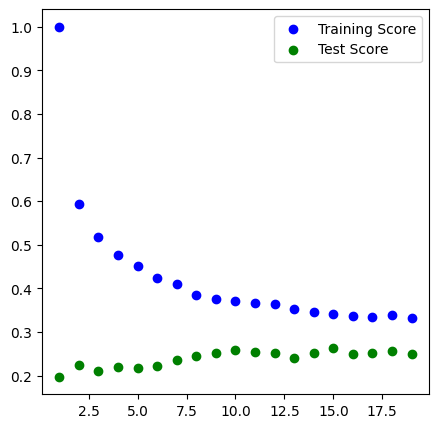

In [324]:
plt.figure(figsize=(5,5))
plt.scatter(K, training, color ='b',label='Training Score')
plt.scatter(K, test, color ='g',label='Test Score')
plt.legend()
# For overlapping scatter plots


In [317]:
#import confusion_matrix
from sklearn.metrics import confusion_matrix
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
#Get accuracy. Note: In case of classification algorithms score method represents accuracy.
knn.score(X_test,y_test)

0.21889952153110048

In [318]:
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)

In [319]:
confusion_matrix(y_test,y_pred)

array([[ 1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 5,  4,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 4, 10,  7,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 1,  1,  5, 16, 13,  7,  3,  1,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  6, 24, 17, 21, 11,  1,  3,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  1,  7, 17, 32, 23, 14,  4,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  8, 14, 37, 45, 20, 13,  2,  2,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  6, 26, 38, 30, 19,  7,  1,  1,  1,  3,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  7, 10, 26, 12, 24,  5,  3,  1,  2,  0,  1,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  2,  8,  8, 13,  9,  5,  2,  1,  1,  0,  0,  0,
         0,  0,  0,

In [320]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.09      0.33      0.14         3
           4       0.24      0.31      0.27        13
           5       0.32      0.22      0.26        32
           6       0.21      0.33      0.26        48
           7       0.20      0.20      0.20        84
           8       0.21      0.32      0.25        99
           9       0.25      0.32      0.28       142
          10       0.25      0.22      0.23       139
          11       0.26      0.26      0.26        93
          12       0.16      0.10      0.12        51
          13       0.00      0.00      0.00        31
          14       0.17      0.04      0.06        26
          15       0.00      0.00      0.00        21
          16       0.20      0.08      0.11        13
          17       0.00      0.00      0.00         8
          18       0.00      0.00      0.00        12
          19       0.00      0.00      0.00         7
          20       0.00    